# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: CNN to classify MNIST digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [39]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Imports
import os, warnings
from matplotlib import gridspec
import pandas as pd
import numpy as np

## Mount to the data drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
data_path = "/content/drive/MyDrive/Colab Notebooks/digit_recognizer/django-social-media-template-main"

# Import the data
 - separate the feature data and label data
 - for training data, we need to separate it further into training and verification data

In [42]:
data = pd.read_csv(data_path + "/train.csv")
print("train data:")
display(data.head())

label = data.iloc[:, 0]
data = data.iloc[:, 1:]

data_test = pd.read_csv(data_path + "/test.csv")
print("test data:")
display(data_test.head())

train data:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


test data:


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
display(data.shape)
display(data_test.shape)

(42000, 784)

(28000, 784)

## Processing the image data
 - normalize the data into the range 0-1
 - show some sample images in matplotlib

In [44]:
dataNorm = data.to_numpy()
normalize_max = np.max(dataNorm)

dataNorm = dataNorm / normalize_max
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

dataNorm_test = data_test.to_numpy()
dataNorm_test = dataNorm_test / normalize_max
dataNorm_test = dataNorm_test.reshape(dataNorm_test.shape[0],1,28,28)

train images:


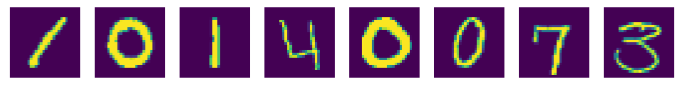

test images:


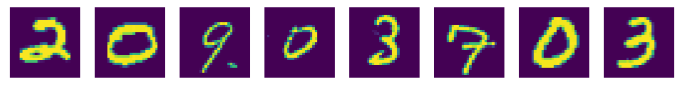

In [45]:
plt.figure(figsize=(12,3))
print("train images:")

for i in range(8):
    image = dataNorm[i,:]
    plt.subplot(1, 8, i+1)
    plt.imshow(np.squeeze(image))
    plt.axis('off')
plt.show()

plt.figure(figsize=(12,3))
print("test images:")
for i in range(8):
    image = dataNorm_test[i,:]
    plt.subplot(1, 8, i+1)
    plt.imshow(np.squeeze(image))
    plt.axis('off')
plt.show()

# Create train/verification/test groups using DataLoader

In [46]:
# Step 1: convert to tensor
dataT   = torch.tensor(dataNorm).float()
labelT = torch.tensor(label).long()

dataT_test = torch.tensor(dataNorm_test).float()

# Step 2: use scikitlearn to split the data
train_data, veri_data, train_labels, veri_labels = train_test_split(dataT, labelT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
veri_data  = TensorDataset(veri_data,veri_labels)
test_data = TensorDataset(dataT_test)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
veri_loader  = DataLoader(veri_data, batch_size=len(veri_data), shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True, drop_last=True)

## Confirm the data size and data type

In [47]:
# check size (should be images X channels X width X height)
display("feature shape:", train_loader.dataset.tensors[0].shape)
display("label shape:", train_loader.dataset.tensors[1].shape)
display("test feature shape:", test_loader.dataset.tensors[0].shape)

'feature shape:'

torch.Size([37800, 1, 28, 28])

'label shape:'

torch.Size([37800])

'test feature shape:'

torch.Size([28000, 1, 28, 28])

In [ ]:
'''
Some notes:
If you were wondering whether you should implement dropout in a convolutional network, now you know. Only use dropout on fully-connected layers, and implement batch normalization between convolutions.
'''

# Create the DL model

In [50]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1, 10, kernel_size=5, stride=1, padding=1)
      # size: np.floor( (28+2*1-3)/1 )+1 = 28 / 2 = 14 (/2 b/c maxpool)
      self.bn1 = nn.BatchNorm2d(num_features=10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
      # size: np.floor( (14+2*1-3)/1 )+1 = 14 /2 = 7 (/2 b/c maxpool)
      self.bn2 = nn.BatchNorm2d(num_features=20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize, 100)

      ### output layer
      self.out = nn.Linear(100,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(self.bn1(F.max_pool2d(self.conv1(x),2)))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(self.bn2(F.max_pool2d(self.conv2(x),2)))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

## Test the model wht one batch and and show model info

In [51]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 14, 14])
Layer conv2/pool2: torch.Size([32, 20, 7, 7])
Vectorize: torch.Size([32, 980])
Layer fc1: torch.Size([32, 100])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3228, grad_fn=<NllLossBackward0>)


In [52]:
# count the total number of parameters in the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 14, 14])
Layer conv2/pool2: torch.Size([2, 20, 7, 7])
Vectorize: torch.Size([2, 980])
Layer fc1: torch.Size([2, 100])
Layer out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 14, 14]              20
            Conv2d-3           [-1, 20, 14, 14]           1,820
       BatchNorm2d-4             [-1, 20, 7, 7]              40
            Linear-5                  [-1, 100]          98,100
            Linear-6                   [-1, 10]           1,010
Total params: 101,090
Trainable params: 101,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.39
Estimated Total Size (MB): 0.50
--------------

# Create a function that trains the model and show the verification metrics

In [53]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 20

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    print(f"Epochi {epochi} starts -------")
    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for k, (X,y) in enumerate(train_loader):
      if k % 500 == 0:
        print(f"Batch {k} ---")

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    veri_X, veri_y = next(iter(veri_loader)) # extract X,y from test dataloader

    with torch.no_grad(): # deactivates autograd
      veri_yHat = net(veri_X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(veri_yHat,axis=1)==veri_y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [54]:
trainAcc,testAcc,losses,net = function2trainTheModel()

Epochi 0 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 1 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 2 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 3 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 4 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 5 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 6 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 7 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 8 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 9 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 10 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 11 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 12 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 13 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 14 starts -------
Batch 0 ---
Batch 500 ---
Batch 1000 ---
Epochi 15 starts ---

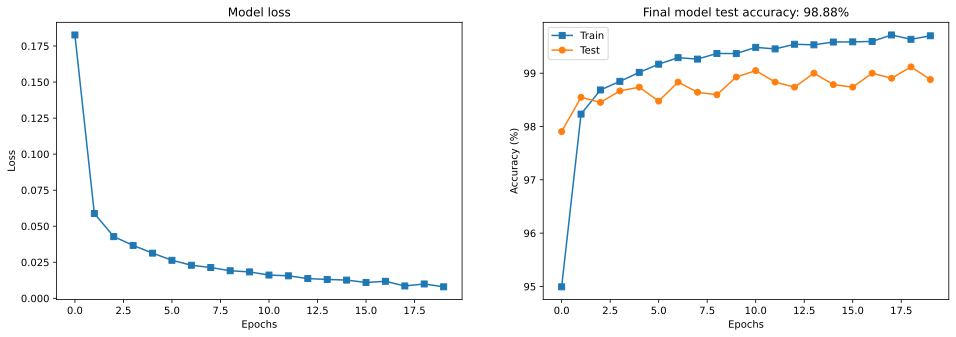

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [55]:
net.eval()
test_X = next(iter(test_loader))
with torch.no_grad(): # deactivates autograd
    test_yHat = net(dataT_test)

print(test_yHat)

tensor([[ -4.7652,  -8.9369,  26.2320,  ...,  -0.4558, -10.6951, -15.0333],
        [ 28.3094, -38.5336,  -6.6667,  ..., -21.1389, -16.7349, -17.3805],
        [-29.5715, -21.2500, -13.0786,  ..., -16.4223,  -9.0712,  20.6994],
        ...,
        [-37.6515, -15.1802, -26.4237,  ..., -15.1303, -12.0678,  -8.0441],
        [-16.5596, -24.6579, -20.9420,  ...,  -9.4974,  -6.0314,  16.7224],
        [-17.1458, -12.0139,  34.2214,  ...,  -3.5109,  -6.8735, -28.0582]])


In [56]:
test_result = torch.argmax(test_yHat,axis=1)

In [57]:
test_data = pd.read_csv(data_path + "/sample_submission.csv")
test_data.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [58]:
test_data['Label'] = test_result
test_data.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [59]:
test_data.to_csv(data_path + "/claudia_submission.csv", index = False)

# Additional explorations

In [ ]:
# 1) Do we need both convolution layers in this model? Comment out the "conv2" layers in the mode definition. What else
#    needs to be changed in the code for this to work with one convolution layer? Once you get it working, how does the
#    accuracy compare between one and two conv layers? (hint: perhaps try adding some more training epochs)
#
#    Your observation here is actually the main reason why MNIST isn't very useful for evaluating developments in DL:
#    MNIST is way too easy! Very simple models do very well, so there is little room for variability. In fact, we'll
#    stop using MNIST pretty soon...
#
#    Final note about MNIST: You probably won't get much higher than 98% with this small dataset. These kinds of CNNs
#    can get >99% test-accuracy with the full dataset (60k samples instead of 18k).
#